# SCF convergence and preconditioning

In this notebook we will investigate the convergence properties of density-mixing SCF algorithms. In the exercises you will then experiment with standard ingredients to build up a state-of-the-art density mixing SCF procedure. The discussion follows a recent publication, where more details can be found:
  - [M. Herbst, A. Levitt. *J. Phys.: Condens. Matter* **33** 085503 (2021) DOI: 10.1088/1361-648x/abcbdb](http://dx.doi.org/10.1088/1361-648x/abcbdb): Black-box inhomogeneous preconditioning for self-consistent field iterations in density functional theory

The central ingredient are **damped, preconditioned fixed-point iteratons**
  $$\rho_{n+1} = \rho_n + \alpha P^{-1} (D(V(\rho_n)) - \rho_n),$$
  where
  * $\alpha$ is a damping parameter, typically chosen between $0$ and $1$.
  * $P^{-1}$ is a preconditioner, which aims to improve convergence (details discussed in a second).
  * the iteratons start from an initial guess $\rho_0$.

The simplest of these iterations is obtained for $\alpha = 1.0$ and $P^{-1} = I$ (identity) and can be implemented in DFTK in just a few lines of code:

In [ ]:
using DFTK

# Standard silicon setup
a = 10.26
lattice = a / 2 * [[0 1 1.];
                   [1 0 1.];
                   [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/si-q4"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]
model  = model_LDA(lattice, atoms)
basis  = PlaneWaveBasis(model; Ecut=10, kgrid=[2, 2, 2]);

function fixed_point_iteration(F, ρ₀, maxiter; tol)
    # Simple fixed-point iteration function performing
    #    ρₙ₊₁ = ρₙ + [F(ρₙ) - ρₙ] = F(ρₙ)
    # F:        The SCF step function
    # ρ₀:       The initial guess density
    # maxiter:  The maximal number of iterations to be performed
    # tol:      The selected convergence tolerance
    
    ρ  = ρ₀
    Fρ = F(ρ)
    for n = 1:maxiter
        Rρ = Fρ - ρ
        # If change less than tolerance, break iterations:
        if norm(Rρ) < tol
            break
        end
        ρ  = Fρ
        Fρ = F(ρ)
    end
    
    # Return some stuff DFTK needs ...
    (fixpoint=ρ, converged=norm(Fρ - ρ) < tol)
end;

# use this algorithm inside DFTK's SCF for solving the silicon problem
# (the other parameters are needed to overwrite some DFTK defaults
#  we don't want to use just yet).
self_consistent_field(basis; solver=fixed_point_iteration, damping=1.0, maxiter=40);

## Analysing SCF convergence

We investigate the convergence properties of damped, preconditioned iterations, in order to understand the choices for the preconditioning strategy $P^{-1}$ as well as the damping parameter $\alpha$ to be made.

Near the fixed point $\rho_\ast = D(V(\rho_\ast))$ the error $e_n = \rho_n - \rho_\ast$ is small and we can expand to first order:
$$ \begin{align*}
D(V(\rho_\ast + e_n)) &\simeq D\left[V(\rho_\ast) + V'|_{\rho_\ast} e_n\right] \\
&\simeq D(V(\rho_\ast)) + D'|_{V(\rho_\ast)} V'|_{\rho_\ast} e_n\\
&= \rho_\ast + D'|_{V(\rho_\ast)} V'|_{\rho_\ast} e_n
\end{align*}$$

The derivatives $D'$ and $V'$ are again important quantities and are given special symbols:
- Hartree-exchange-correlation **kernel** $K = V'$
- Independent-particle **susceptibility** $\chi_0 = D'$

where for simplicity it has been dropped that these quantities are evaluated at the fixed-point,
 i.e. at $\rho_\ast$ and $V(\rho_\ast)$, respectively.
 
 The above expansion allows to relate the **error between SCF iterations** (near the fixed point):
$$ \begin{align*}
e_{n+1} = \rho_{n+1} - \rho_\ast 
&= \rho_{n} - \rho_\ast + \alpha P^{-1} [D(V(\rho_\ast + e_n)) - \rho_n] \\
&\simeq \rho_{n} - \rho_\ast + \alpha P^{-1} [\rho_\ast + \chi_0 K e_n - \rho_n] \\
&= e_n - \alpha P^{-1} [1 - \chi_0 K] e_n.
\end{align*}$$

Introducing the **dielectric matrix** adjoint
$$ \varepsilon^\dagger = [1 - \chi_0 K] $$
leads to the final relationship
$$ e_{n+1} \simeq [1 - \alpha P^{-1} \varepsilon^\dagger] e_n = [1 - \alpha P^{-1} \varepsilon^\dagger]^n e_0$$
with $e_0$ being the initial error. The SCF Jacobian is
$1 - \alpha P^{-1} \varepsilon^\dagger.$

In other words:
$$\text{SCF converges} \qquad \Leftrightarrow \qquad \text{eigenvalues of $1 - \alpha P^{-1} \varepsilon^\dagger$ are between $-1$ and $1$}$$

This implies that the **convergence** properties of an SCF
are related to $\varepsilon$, the dielectric operator,
which **depends on** the **dielectric properties** of the system under study.

In other words it depends on the conduction and screening properties, i.e. whether the material is an insulator, a semiconductor, a metal etc.

## Making an SCF converge

It turns out that for the largest chunk of cases the eigenvalues of $\varepsilon^\dagger$ are positive. Moreover near a local minimiser $\varepsilon^\dagger$ always has non-degative spectrum.

To make the SCF converge one can therefore:
- Choose $\alpha$ small enough. Even for $P = I$ this always works, but convergence can be painfully slow. (see e.g. the proof in [M. Herbst, A. Levitt *J. Comp. Phys.* **459** 111127 (2022). DOI 10.1016/j.jcp.2022.111127](http://dx.doi.org/10.1016/j.jcp.2022.111127))
- Find a good $P^{-1} \simeq (\varepsilon^\dagger)^{-1}$. Then the eigenvalues of $(P^{-1} \varepsilon^\dagger)$ are close to 1, $\alpha \simeq 1$ is a good choice and the SCF converges in few steps. Hooray!
- The optimal $\alpha$ and the optimal rate of convergence are directly related to the eigenvalues of $P^{-1} \varepsilon^\dagger$. Denoting by $\lambda_\text{min} > 0$ and $\lambda_\text{max}$ the smallest and largest eigenvalues of $P^{-1} \varepsilon^\dagger$, then the optimal damping is
 $$ \alpha = \frac{2}{\lambda_\text{min} + \lambda_\text{max}}$$
  and the rate of convergence is (for large $\kappa$)
 $$ R \simeq 1 - \frac{2}{\kappa} $$
  where the (spectral) condition number
  $$ \kappa = \frac{\lambda_\text{max}}{\lambda_\text{min}}.$$
  Thus the smaller the condition number, the better the convergence.

**Note:** If the preconditoner is very bad, the eigenvalues of $(P^{-1} \varepsilon^\dagger)$ might even be worse than $\varepsilon^\dagger$, such that convergence is actually hampered by the preconditioner. We will see examples of that in a minute.

## Acceleration techniques

Anderson acceleration (to be discussed in the exercises)

Mathematical analysis not very much advanced

See paper by Mi-Song

Relation to GMRES results in improved rate of convergence as

$$ R \simeq 1 - \frac{2}{\sqrt{\kappa}} $$


## Metals and charge sloshing

Recall the definition $\varepsilon^\dagger = 1 - \chi_0 K$. The Hartree-exchange-correlation kernel can be further decomposed into
$$ K = v_c + K_\text{xc}, $$
where $v_c$ is the classical Coulomb kernel we introduced previously and $K_\text{xc} = d^2 E_\text{xc}(\rho)$ is the Hessian of the exchange-correlation energy functional.

For well-behaved systems the smallest eigenvalue of $\varepsilon^\dagger$ is around $1$ while the largest eigenvalue is of order $10$. Due to a number of instabilities in the modelled systems either the smallest eigenvalue can decrease or the largest eigenvalue can increase, thus giving a larker condition number $\kappa$ and worse convergence. For a detailed discussion, see Section 2 of [M. Herbst, A. Levitt. *J. Phys.: Condens. Matter* **33** 085503 (2021) DOI: 10.1088/1361-648x/abcbdb](http://dx.doi.org/10.1088/1361-648x/abcbdb).

In this discussion we will restrict ourselves to a single source of instabilities, namely the one due to the long range divergence of the Coulomb kernel $v_c$. Indeed, if $\hat{\rho}(q)$ are the Fourier coefficients of the density, then
$$ \widehat{(v_c \rho)}(q) = \frac{4\pi \hat{\rho}(q)}{|q|^2} $$,
which diverges for small $q$ (long wavelength). If this divergence is not compensated by $\chi_0$, this can manifest in large eigenvalues of $\varepsilon^\dagger$. (Note that $\chi_0$ is non-positive operator and $K_\text{xc}$ has usually little influence on the large eigenmodes of $\varepsilon^\dagger$.)

For **metals** it turns out that $\chi_0$ is approximately constant in the long-wavelength limit ($q \to 0$), namely the negative density of states $D$ at the Fermi level:
$$\lim_{q\to0} \chi_0(q) \simeq -D.$$
Therefore as one treats larger and larger metallic systems, smaller wavelengths $q$ become accessible in the discretised problem, which causes $\lambda_\text{max}$ to increase --- in theory quadratically with system size. This phaenomenon, known as **charge sloshing** makes it difficult to treat large metallic systems without proper preconditioning.

In contrast for **insulators** and **semiconductors** a good approximation of $\chi_0(q)$ for small $q$ is $-q^T \sigma_0 q$, where $\sigma_0$ is a material-dependent symmetric positive matrix. Therefore the $1/q^2$ instability is compensated and treating larger cells is less difficult.

## Preconditioning strategies

The natural approach to deal with the large-wavelength instabilities mentioned in the previous section, is to develop an approximate dielectric model $P \simeq \varepsilon^\dagger$, which can be used to compensate the large eigenvalues of $\varepsilon^\dagger$, i.e. such that $P^{-1} \varepsilon^\dagger$ keeps a manageable condition number $\kappa$ and thus a fast SCF convergence.

Throughout this section we will employ the so-called **random-phase approximation**, where we set $K \simeq v_c$, i.e. $\varepsilon^\dagger = 1 - \chi_0 v_c$.


### Bulk dielectric models

The most practical strategy is to directly propose analytical expressions for $P^{-1} \simeq (\varepsilon^\dagger)^{-1}$, which are fast to evaluate, thus cause little computational overhead in the SCF. This is feasible for **bulk materials**, where it is justified to ignore lattice-scale details, i.e (a) take the $q\to0$ limit and (b) model $\chi_0$ as a translation-independent operator characterised by its Fourier multiplier $\chi_0(q)$. Since $v_c$ is also translation-independent this implies in particular $P^{-1}(q) = \frac{1}{P(q)}$, i.e. that an approximate model for $\varepsilon^\dagger(q)$ (the $P(q)$) can directly be used to analytically compute $P^{-1}(q)$.

For **metals** the observation $\lim_{q\to0} \chi_0(q) \simeq -D$ directly leads to the **Kerker preconditioner**
$$ P_\text{Kerker}^{-1}(q) = \left( 1 - \frac{4\pi -D}{|q|^2} \right)^{-1} = \frac{|q|^2}{|q|^2 + 4\pi D}. $$
The Kerker preconditioner is available in DFTK as `KerkerMixing` and `KerkerDosMixing` (which automatically determines the density of states from the current orbitals and occupations).

For **semiconductors** and **insulators** one can identify $\varepsilon_r = \varepsilon(q = 0) = 1 + 4\pi \sigma_0$ (in the case of isotropic $\sigma_0$), where $\varepsilon_r$ can be interpreted as the macroscopic electronic dielectric constant. From this limit for long wavelengths a number of empirical models for $\chi_0(q)$ and $\varepsilon^\dagger(q)$ have been proposed in the literature. A simple, two-parameter model is
$$
P_\text{Dielectric}^{-1}(q) = \frac{\varepsilon_r + (\varepsilon_r-1) \frac{|q|^2}{k_\text{TF}^2}}{1 + (\varepsilon_r-1) \frac{|q|^2}{k_\text{TF}^2}},
$$
where $k_\text{TF}$ is another parameter.
This model is available in DFTK as `DielectricMixing`.

Below is a sketch of the three models using the appropriate setups for aluminium (a metal), gallium arsenide (a semiconductor, $\varepsilon_r = 14.9$) and silica (an insulator, $\varepsilon_r = 1.5$):

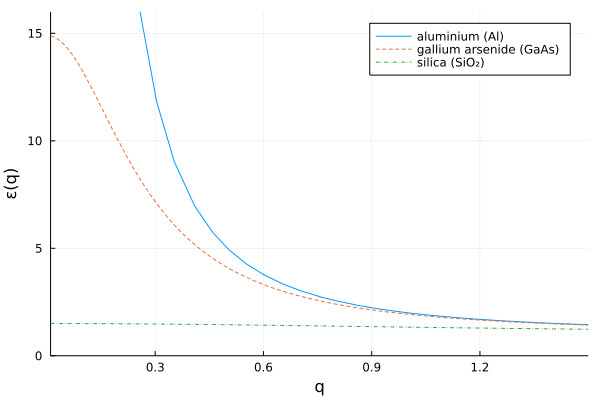

In [15]:
using Plots

χ0_metal(q, kTF=1) = -kTF^2 / 4π
χ0_dielectric(q, εr, C₀=1-εr, kTF=1) = C₀*q^2 / (4π * (1 - C₀*q^2/kTF^2))
χ0_GaAs(q) = χ0_dielectric(q, 14.9)
χ0_SiO2(q) = χ0_dielectric(q, 1.5)
ε(χ0, q) = (1 - 4π/q^2 * χ0(q))

p = plot(xlims=(1e-2, 1.5), ylims=(0, 16), xlabel="q", ylabel="ε(q)", lw=4)
plot!(p, x -> ε(χ0_metal, x), label="aluminium (Al)")
plot!(p, x -> ε(χ0_GaAs, x),  label="gallium arsenide (GaAs)", ls=:dash)
plot!(p, x -> ε(χ0_SiO2, x),  label="silica (SiO₂)", ls=:dashdot)

As expected from this discussion, for insulators $P = I$ (no preconditioner) is sufficient, while for the two other cases, an appropriate preconditioner is needed to ensure good convergence properties for large systems.

Here we show the results for three large bulk systems (40 unit cells) of the three materials:


|   Aluminium (a metal)                                     |   Gallium arsenide (a semiconductor)   |   Silica (an insulator)   |
| :-------------------------------------------------------: | :------------------------------------: | :-------: |
| <img src="img/Al_repeat_40.png" width=300 />   | <img src="img/GaAs_repeat_40.png" width=300 /> | <img src="img/SiO2_repeat_39.png" width=300 /> |

### Susceptibility models and LDOS preconditioner

While the bulk preconditioning models mentioned above are a good step forward, they have two key disadvantages:
1. Since the preconditioner models (especially between metals and insulators) are rather distinct, the preconditioner needs to match the modelled material to ensure fast convergence for large systems. In other words one needs to know **a priori** what material one is modelling.
2. Being by nature bulk models, they miss important applications featuring inhomogeneous systems, such as catalytic surfaces, metal clusters etc.

In order to overcome the second point it is important to realise that we need to give up on the translational independence of $\chi_0$, i.e. we no longer are able to compute $P^{-1}(q)$ by $1/P(q)$. Our strategy will therefore be to construct more sophisticated approximations to $\chi_0$, denoted by $\widetilde{\chi_0}$. The preconditioned density $x_n = P^{-1} \rho_n = (1 - \widetilde{\chi_0} v_c)^{-1}$ is then obtained by solving
$$ (1 - \widetilde{\chi_0} v_c) x_n = \rho_n $$
iteratively using GMRES.

Note that $\chi_0(r, r')$ has unit-cell internal fluctuations, but is overall diagonal dominant
  <img src="img/chi0.png" width=400 />
Starting from the Adler-Wiser formula
  $$\begin{align*}
                \chi_0(\vec{r}, \vec{r}')
                &= \sum_{n, m} \frac{f_\text{FD}(\varepsilon_n) - f_\text{FD}(\varepsilon_m)}{\varepsilon_n - \varepsilon_m}                \psi_n(\vec{r}) \psi_m^\ast(\vec{r})
                \psi_m(\vec{r}') \psi_n^\ast(\vec{r}')%\\
            \end{align*}
            $$
we want to capture the large-scale variations from $\rho_n$ to $\rho_{n+1}$ to counteract the charge-sloshing. Set $V = v_c \rho_n$ and assume $\vec{r} \mapsto \chi_0(\vec{r}, \vec{r}')$ to be more localised around $\vec{r}'$ than $V(\vec{r}')$. Then apply *row-sum mass lumping:*
  $$\begin{align*}
                \int \chi_0(\vec{r}, \vec{r}') V(\vec{r}') d\vec{r}'
                &\simeq V(\vec{r})\int \chi_0(\vec{r}, \vec{r}') d\vec{r}'\\
                &= V(\vec{r}) \sum_{n, m} \frac{f(\varepsilon_n) - f(\varepsilon_m)}
                    {\varepsilon_n - \varepsilon_m}
                    \psi_n(\vec{r}) \psi_m^\ast(\vec{r}) \delta_{mn}\\
                &= V(\vec{r}) \sum_n f'(\varepsilon_n) |\psi_n(\vec{r})|^2\\
                &= V(\vec{r}) \cdot \Big(- \text{LDOS}(\vec{r}) \Big)
            \end{align*}$$

Overall we thus approximate
$$ \chi_0(r, r') \simeq - \text{LDOS}(r) \, \delta(r, r') $$

Note that this is a generic framework, where further terms (capturing other physics of $\chi_0$) could be easily employed on top of the $-\text{LDOS}$ term.

To conclude this chapter we show some results for mixed systems featuring various combinations of metals, insulators and semiconductors. In the table both the number of iterations as well as the condition number is shown. Cases where the condition number does not more than double as the system size is doubled are coloured.

<img src="img/ldos_table.png" width=500 />

For the two metal-insulator systems, exemplary convergence curves are shown below:

|   Aluminium + Vacuum     |   Aluminium + Silica    |
| :---------------------------------: | :----------------: |
| <img src="img/alvac.png" width=400 /> | <img src="img/alsio2.png" width=400 /> |
| <img src="img/AlVac_repeat_20.png" width=400 />   | <img src="img/AlSiO2H_repeat_20.png" width=400 /> |



The LDOS preconditioning strategy is available in DFTK as `LdosMixing`. Since it is parameter-free and applicable to a wide range of systems (any mixture of insulator and metals), it is used by default in DFTK.